In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


In [3]:
!unzip "/content/GTSRB (2).zip"

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: GTSRB/test_modified/26/04314.png  
  inflating: GTSRB/test_modified/26/04698.png  
 extracting: GTSRB/test_modified/26/05000.png  
 extracting: GTSRB/test_modified/26/05176.png  
 extracting: GTSRB/test_modified/26/05251.png  
 extracting: GTSRB/test_modified/26/06200.png  
 extracting: GTSRB/test_modified/26/06258.png  
 extracting: GTSRB/test_modified/26/06338.png  
 extracting: GTSRB/test_modified/26/07080.png  
 extracting: GTSRB/test_modified/26/08677.png  
  inflating: GTSRB/test_modified/26/08702.png  
 extracting: GTSRB/test_modified/26/09019.png  
 extracting: GTSRB/test_modified/26/09177.png  
 extracting: GTSRB/test_modified/26/09570.png  
 extracting: GTSRB/test_modified/26/09927.png  
 extracting: GTSRB/test_modified/26/10096.png  
 extracting: GTSRB/test_modified/26/10869.png  
  inflating: GTSRB/test_modified/26/11183.png  
  inflating: GTSRB/test_modified/26/11263.png  
 extracting: GTSRB/test_modified/

In [4]:
TRAIN_DIR = "/content/GTSRB/train_modified"
TEST_DIR  = "/content/GTSRB/test_modified"

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS_STAGE1 = 10   # frozen base
EPOCHS_STAGE2 = 10   # fine-tuning


In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3977 images belonging to 43 classes.
Found 1983 images belonging to 43 classes.


In [6]:
num_classes = train_generator.num_classes

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# αρχικά freeze όλα τα layers
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,596,971 (9.91 MB)

 Trainable params: 338,987 (1.29 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
num_classes = train_generator.num_classes

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# αρχικά freeze όλα τα layers
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,596,971 (9.91 MB)

 Trainable params: 338,987 (1.29 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    "mobilenetv2_gtsrb_stage1_best.h5",
    save_best_only=True
)

history_stage1 = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS_STAGE1,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.2183 - loss: 3.1471

125/125 ━━━━━━━━━━━━━━━━━━━━ 68s 511ms/step - accuracy: 0.2190 - loss: 3.1430 - val_accuracy: 0.4766 - val_loss: 1.8547
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.4782 - loss: 1.7989

125/125 ━━━━━━━━━━━━━━━━━━━━ 55s 436ms/step - accuracy: 0.4783 - loss: 1.7983 - val_accuracy: 0.5522 - val_loss: 1.5128
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.5522 - loss: 1.4477

125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 503ms/step - accuracy: 0.5522 - loss: 1.4476 - val_accuracy: 0.5860 - val_loss: 1.3207
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.6015 - loss: 1.2424

125/125 ━━━━━━━━━━━━━━━━━━━━ 54s 431ms/step - accuracy: 0.6015 - loss: 1.2424 - val_accuracy: 0.5794 - val_loss: 1.2999
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.6305 - loss: 1.1353

125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 427ms/step - accuracy: 0.6305 - loss: 1.1351 - val_accuracy: 0.6006 - val_loss: 1.2260
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.6633 - loss: 1.0352

125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 466ms/step - accuracy: 0.6633 - loss: 1.0351 - val_accuracy: 0.6314 - val_loss: 1.1653
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.6826 - loss: 0.9709

125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 452ms/step - accuracy: 0.6826 - loss: 0.9709 - val_accuracy: 0.6339 - val_loss: 1.1378
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.7002 - loss: 0.8885

125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 453ms/step - accuracy: 0.7002 - loss: 0.8886 - val_accuracy: 0.6263 - val_loss: 1.1250
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 54s 430ms/step - accuracy: 0.7247 - loss: 0.8363 - val_accuracy: 0.6137 - val_loss: 1.1699
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.7203 - loss: 0.8152

125/125 ━━━━━━━━━━━━━━━━━━━━ 54s 434ms/step - accuracy: 0.7203 - loss: 0.8152 - val_accuracy: 0.6475 - val_loss: 1.0682


In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    "mobilenetv2_gtsrb_stage1_best.h5",
    save_best_only=True
)

history_stage1 = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS_STAGE1,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.7322 - loss: 0.8027

125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 466ms/step - accuracy: 0.7322 - loss: 0.8025 - val_accuracy: 0.6536 - val_loss: 1.0694
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.7468 - loss: 0.7434

125/125 ━━━━━━━━━━━━━━━━━━━━ 54s 430ms/step - accuracy: 0.7468 - loss: 0.7435 - val_accuracy: 0.6566 - val_loss: 1.0535
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 51s 409ms/step - accuracy: 0.7617 - loss: 0.6952 - val_accuracy: 0.6576 - val_loss: 1.0736
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7466 - loss: 0.7411

125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 463ms/step - accuracy: 0.7467 - loss: 0.7409 - val_accuracy: 0.6692 - val_loss: 1.0478
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.7773 - loss: 0.6718 - val_accuracy: 0.6596 - val_loss: 1.0707
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 425ms/step - accuracy: 0.7811 - loss: 0.6578 - val_accuracy: 0.6415 - val_loss: 1.0901
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 417ms/step - accuracy: 0.7779 - loss: 0.6537 - val_accuracy: 0.6480 - val_loss: 1.0810
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 419ms/step - accuracy: 0.7815 - loss: 0.6334 - val_accuracy: 0.6465 - val_loss: 1.1075
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 414ms/step - accuracy: 0.7867 - loss: 0.6135 - val_accuracy: 0.6228 - val_loss: 1.1585


In [11]:
test_loss_1, test_acc_1 = model.evaluate(test_generator, verbose=0)
print(f" Test Accuracy μετά το Stage 1 (frozen base): {test_acc_1:.4f}")


 Test Accuracy μετά το Stage 1 (frozen base): 0.6692


In [12]:
# ξεπαγώνουμε τα τελευταία ~30 layers
fine_tune_at = len(base_model.layers) - 30

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint_ft = ModelCheckpoint(
    "mobilenetv2_gtsrb_finetuned_best.h5",
    save_best_only=True
)

history_stage2 = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS_STAGE2,
    callbacks=[early_stop, checkpoint_ft],
    verbose=1
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.6330 - loss: 1.2204

125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 543ms/step - accuracy: 0.6333 - loss: 1.2190 - val_accuracy: 0.5724 - val_loss: 1.3955
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.7668 - loss: 0.7112

125/125 ━━━━━━━━━━━━━━━━━━━━ 67s 537ms/step - accuracy: 0.7668 - loss: 0.7113 - val_accuracy: 0.5946 - val_loss: 1.3430
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 68s 541ms/step - accuracy: 0.8011 - loss: 0.5757 - val_accuracy: 0.5875 - val_loss: 1.4018
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.8279 - loss: 0.5044

125/125 ━━━━━━━━━━━━━━━━━━━━ 70s 557ms/step - accuracy: 0.8279 - loss: 0.5045 - val_accuracy: 0.6172 - val_loss: 1.3420
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.8438 - loss: 0.4643

125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 608ms/step - accuracy: 0.8438 - loss: 0.4641 - val_accuracy: 0.6778 - val_loss: 1.1051
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8660 - loss: 0.3942

125/125 ━━━━━━━━━━━━━━━━━━━━ 67s 539ms/step - accuracy: 0.8660 - loss: 0.3943 - val_accuracy: 0.6899 - val_loss: 1.0662
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 67s 533ms/step - accuracy: 0.8730 - loss: 0.3632 - val_accuracy: 0.6747 - val_loss: 1.1520
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8885 - loss: 0.3134

125/125 ━━━━━━━━━━━━━━━━━━━━ 69s 552ms/step - accuracy: 0.8886 - loss: 0.3134 - val_accuracy: 0.7262 - val_loss: 1.0086
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 68s 542ms/step - accuracy: 0.9005 - loss: 0.3040 - val_accuracy: 0.7075 - val_loss: 1.0476
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 70s 563ms/step - accuracy: 0.9029 - loss: 0.2788 - val_accuracy: 0.6788 - val_loss: 1.2434


In [13]:
test_loss_2, test_acc_2 = model.evaluate(test_generator, verbose=0)
print(f" Τελικό Test Accuracy (fine-tuned MobileNetV2 στο GTSRB): {test_acc_2:.4f}")


 Τελικό Test Accuracy (fine-tuned MobileNetV2 στο GTSRB): 0.7262


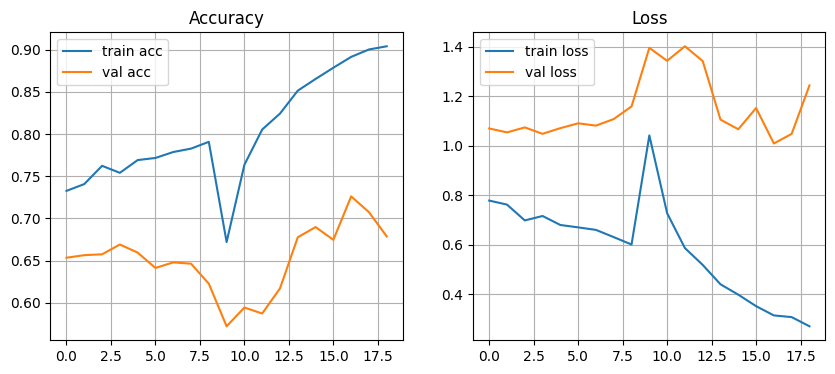

In [14]:
plt.figure(figsize=(10,4))

# accuracy
plt.subplot(1,2,1)
plt.plot(history_stage1.history['accuracy'] + history_stage2.history['accuracy'], label='train acc')
plt.plot(history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.grid()

# loss
plt.subplot(1,2,2)
plt.plot(history_stage1.history['loss'] + history_stage2.history['loss'], label='train loss')
plt.plot(history_stage1.history['val_loss'] + history_stage2.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.grid()

plt.show()


62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step
📊 Classification Report (MobileNetV2 fine-tuned):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.93      0.54      0.69       114
          10       0.61      0.98      0.75       104
          11       0.63      0.92      0.75        66
          12       0.95      0.90      0.92       109
          13       0.97      0.98      0.98       114
          14       1.00      0.79      0.88        42
          15       0.94      0.97      0.96        33
          16       0.90      0.83      0.86        23
          17       1.00      0.91      0.95        57
          18       0.87      0.87      0.87        61
          19       0.50      0.33      0.40         9
           2       0.63      0.71      0.67       118
          20       0.12      0.07      0.09        14
          21       0.27      0.43      0.33        14
          22       0.46      0.68      0.55

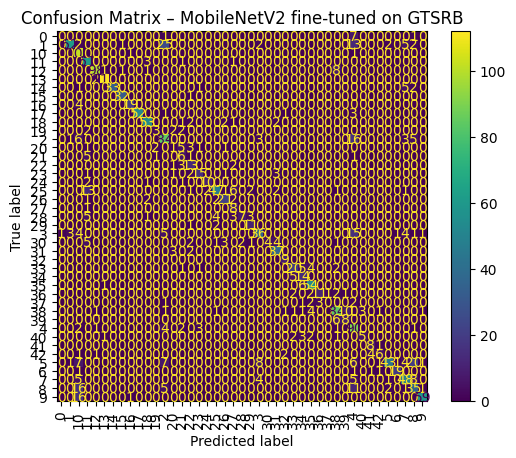

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

test_generator.reset()
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

print(" Classification Report (MobileNetV2 fine-tuned):")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=test_generator.class_indices.keys())
disp.plot(xticks_rotation=90)
plt.title("Confusion Matrix – MobileNetV2 fine-tuned on GTSRB")
plt.show()
